### Credit Card Fraud Detection


#### Datasource
https://www.kaggle.com/datasets/kartik2112/fraud-detection

#### About the dataset
This is a simulated credit card transaction dataset containing legitimate and fraud transactions from the duration 1st Jan 2019 - 31st Dec 2020. It covers credit cards of 1000 customers doing transactions with a pool of 800 merchants.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import time

from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from category_encoders import JamesSteinEncoder

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score,classification_report,balanced_accuracy_score,precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB,MultinomialNB


#### Data Analysis

In [5]:
card_transaction_df = pd.read_csv('data/fraudTrain.csv')
card_transaction_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [6]:
card_transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

##### Check the Nulls count in the dataframe

In [7]:
print(card_transaction_df.isnull().sum())

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


##### Number of fraud and non fraud transactions

In [8]:
card_transaction_df['is_fraud'].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [9]:
num_unique_merchants = card_transaction_df['merchant'].nunique()
print(f"Number of unique merchants: {num_unique_merchants}")

# Unique values in 'state'
num_unique_states = card_transaction_df['state'].nunique()
print(f"Number of unique states: {num_unique_states}")

# Unique values in 'category'
num_unique_categories = card_transaction_df['category'].nunique()
print(f"Number of unique categories: {num_unique_categories}")

Number of unique merchants: 693
Number of unique states: 51
Number of unique categories: 14


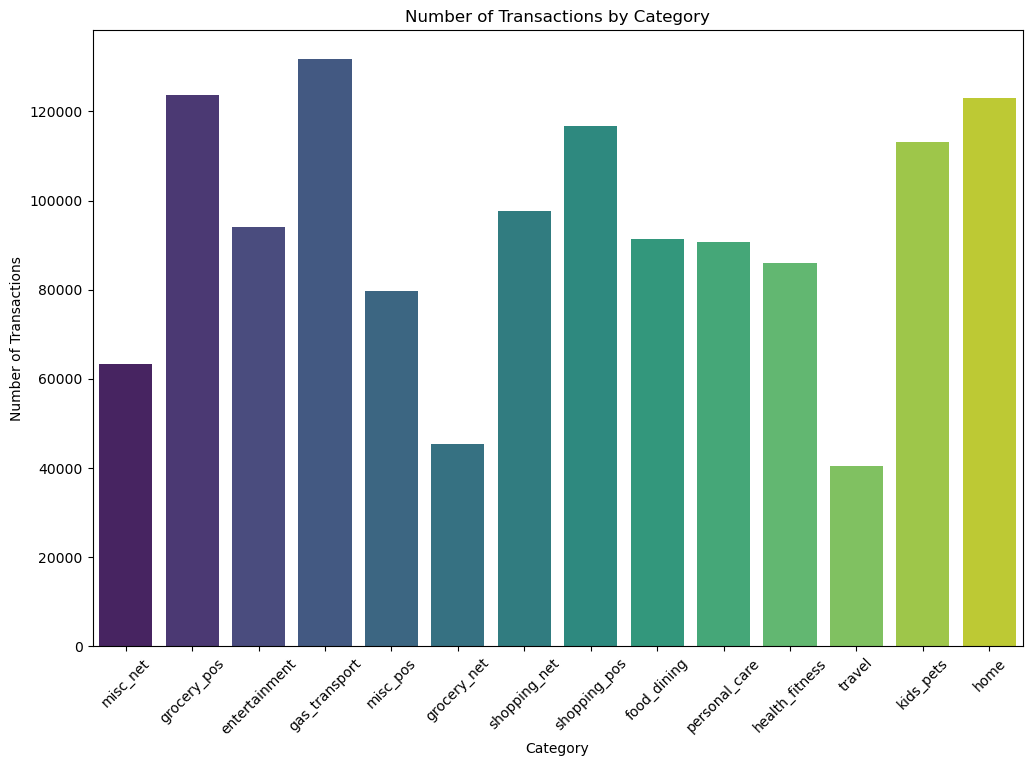

In [10]:
plt.figure(figsize=(12, 8))
sns.countplot(data=card_transaction_df, x='category', palette='viridis')
plt.xticks(rotation=45)
plt.title('Number of Transactions by Category')
plt.xlabel('Category')
plt.ylabel('Number of Transactions')
plt.show()

#### Gas transactions are more compared to the other ones

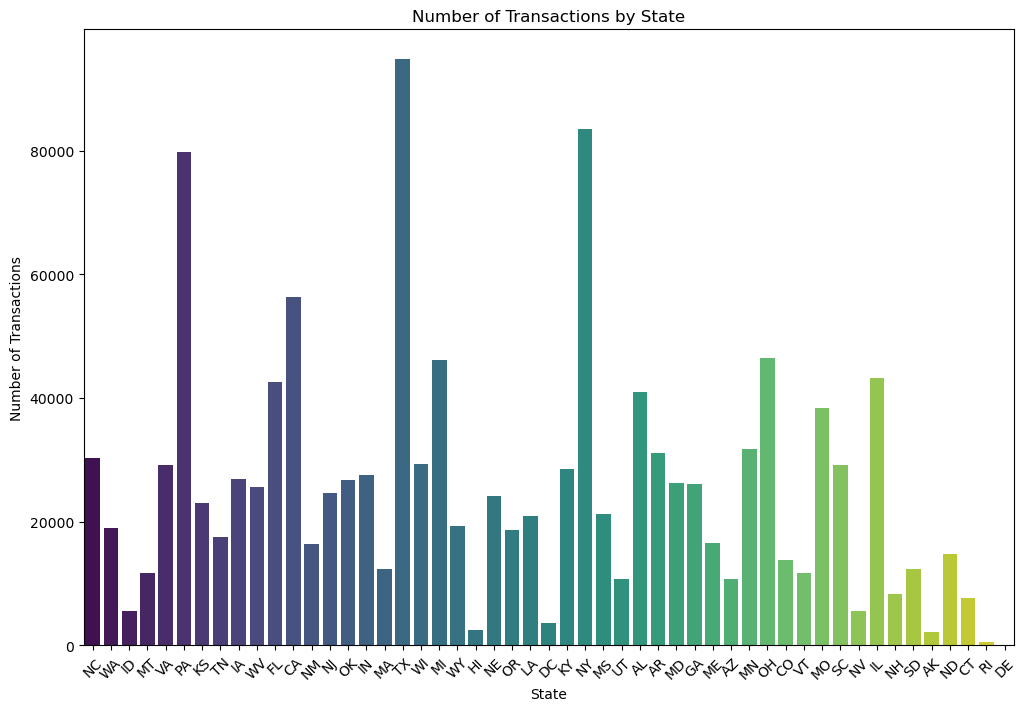

In [11]:
plt.figure(figsize=(12, 8))
sns.countplot(data=card_transaction_df, x='state', palette='viridis')
plt.xticks(rotation=45)
plt.title('Number of Transactions by State')
plt.xlabel('State')
plt.ylabel('Number of Transactions')
plt.show()


#### Transactions in Texas are more compared to other states

In [12]:
fraud_transactions_df = card_transaction_df.query("is_fraud == 1")

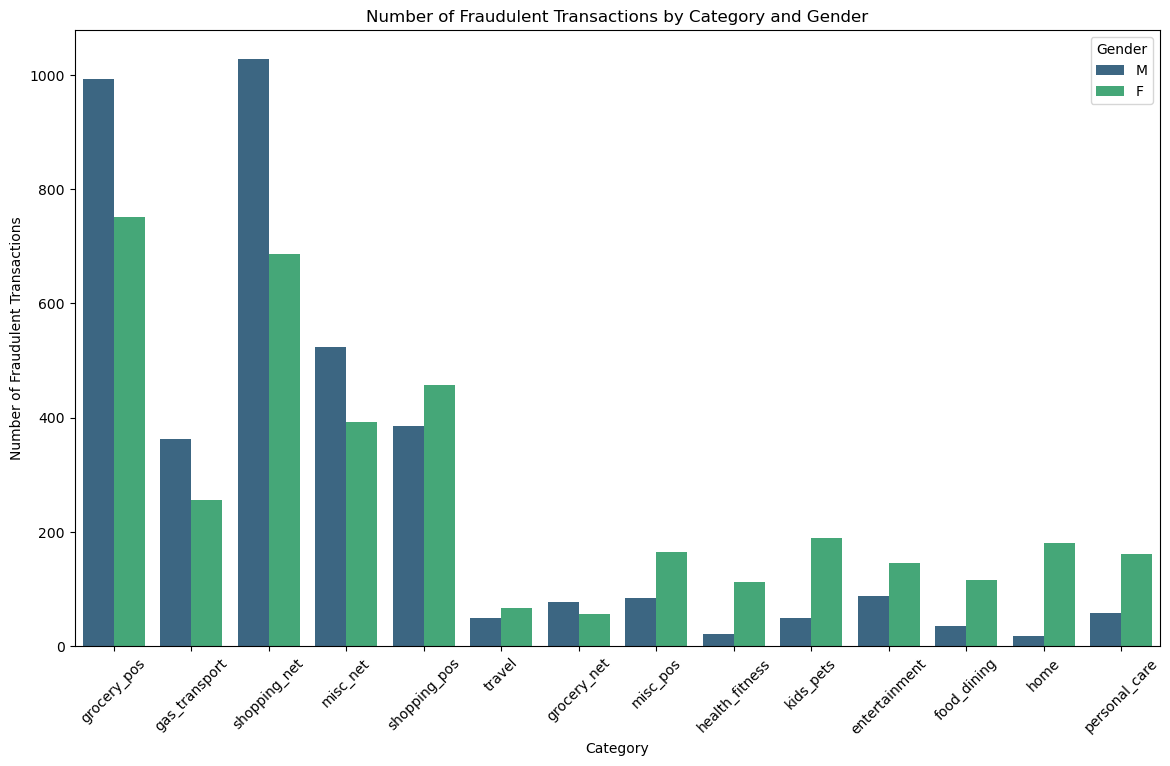

In [13]:
plt.figure(figsize=(14, 8))  # Adjust figsize as needed
sns.countplot(data=fraud_transactions_df, x='category', hue='gender', palette='viridis')

# Add titles and labels
plt.title('Number of Fraudulent Transactions by Category and Gender')
plt.xlabel('Category')
plt.ylabel('Number of Fraudulent Transactions')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show the plot
plt.legend(title='Gender')
plt.show()

#### There are some categories where males have more fraudulent and some where females have more fraudulent transactions

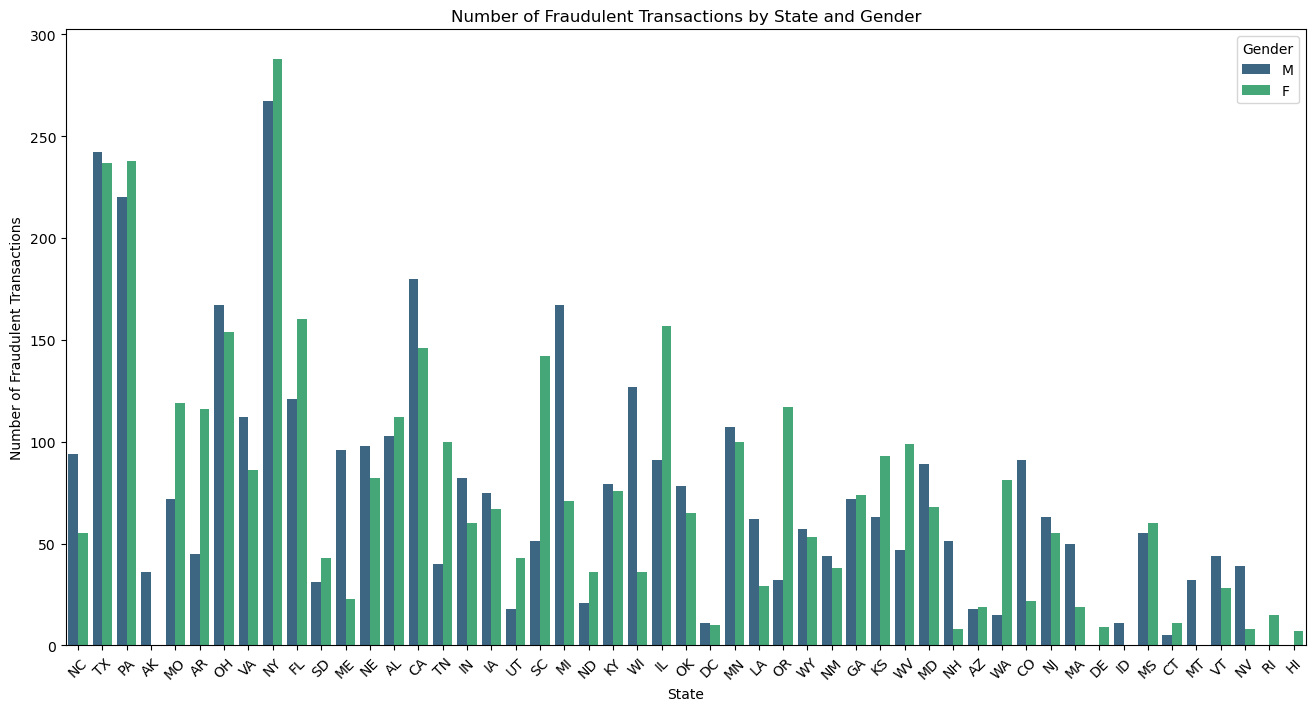

In [14]:
plt.figure(figsize=(16, 8))  # Adjust figsize as needed
sns.countplot(data=fraud_transactions_df, x='state', hue='gender', palette='viridis')

# Add titles and labels
plt.title('Number of Fraudulent Transactions by State and Gender')
plt.xlabel('State')
plt.ylabel('Number of Fraudulent Transactions')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.legend(title='Gender')
plt.show()

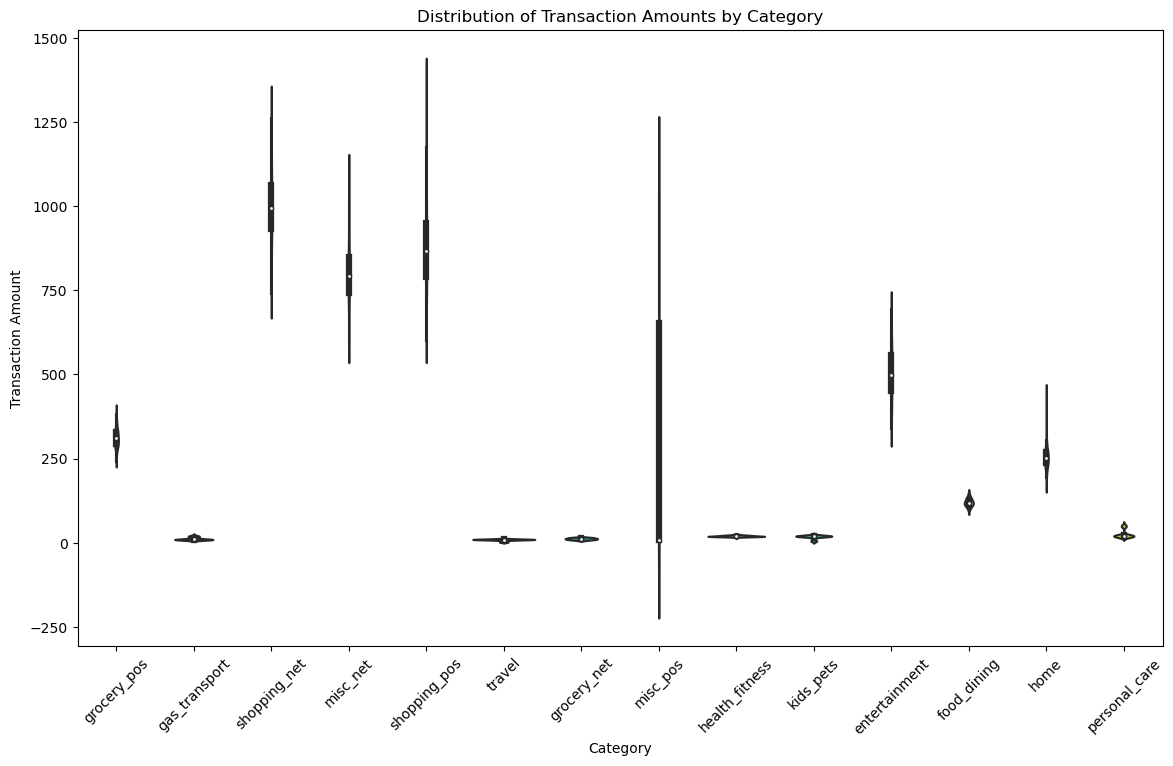

In [15]:
plt.figure(figsize=(14, 8))  # Adjust figsize as needed
sns.violinplot(data=fraud_transactions_df, x='category', y='amt', palette='viridis')

# Add titles and labels
plt.title('Distribution of Transaction Amounts by Category')
plt.xlabel('Category')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=45)
plt.show()

#### All fraudulent transactions are less than 1500

### Dropping less important columns

In [16]:
cleaned_up_df = card_transaction_df.drop(columns=['Unnamed: 0','cc_num','trans_num','first','last','merchant','zip','city_pop','street','unix_time'],axis=1)


In [17]:
# Add just the hour of the day and ignore the other time fields.
cleaned_up_df['transaction_hour'] = pd.to_datetime(card_transaction_df['trans_date_trans_time'],format="%Y-%m-%d %H:%M:%S").dt.hour
cleaned_up_df.drop('trans_date_trans_time',axis=1,inplace=True)

In [18]:
# Derive age from dob
current_year = datetime.date.today().year
cleaned_up_df['customer_age'] = current_year - pd.to_datetime(cleaned_up_df['dob']).dt.year
cleaned_up_df.drop('dob',axis=1,inplace=True)

In [19]:
cleaned_up_df.drop('city',axis=1,inplace=True)

In [20]:
X = cleaned_up_df.drop('is_fraud',axis=1)
y = cleaned_up_df['is_fraud']

### Do the encoding

In [21]:
X = JamesSteinEncoder().fit_transform(X,y)


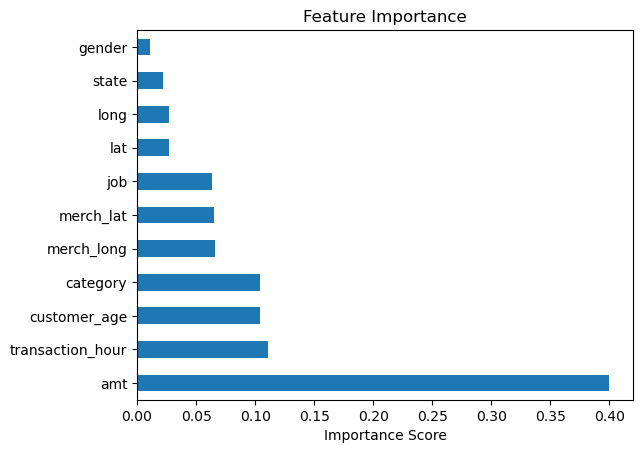

In [22]:
model = ExtraTreesClassifier(n_jobs=-1)
model.fit(X, y)
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.nlargest(20).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.show()

### Scale Features

In [23]:
X = StandardScaler().fit_transform(X)

### Running Models

* Logistic Regression
* KNN
* Decision Tree
* SVM

In [24]:
X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.2,random_state=42)


In [25]:
def plot_confusion_matrix(y_test,classifier,X_test,title): 
    cm = confusion_matrix(y_test,classifier.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classifier.classes_)
    disp.plot()
    disp.ax_.set_title(title)


def hyper_parameter_tuning(model,grid_params):
    gs = GridSearchCV(model,param_grid=grid_params, scoring="accuracy", cv=5,n_jobs=-1).fit(X_train,y_train)
    return gs

model_test_scores = {}
balanced_accuracy_scores_dict = {}
precision_dict = {}
recall_dict = {}
f1_score_dict = {}


def measure_scores(clf,X_test,y_test,model_name):
    y_preds = clf.predict(X_test)
    balanced_accuracy_scores_dict[model_name] = balanced_accuracy_score(y_test,y_preds)
    precision,recall,f1,support = precision_recall_fscore_support(y_test,y_preds,average='binary')
    precision_dict[model_name] = precision
    recall_dict[model_name] = recall
    f1_score_dict[model_name] = f1
    model_test_scores[model_name]=clf.score(X_test,y_test)

#### Logistic Regression

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sk

LogisticRegression(C=0.5, n_jobs=-1)


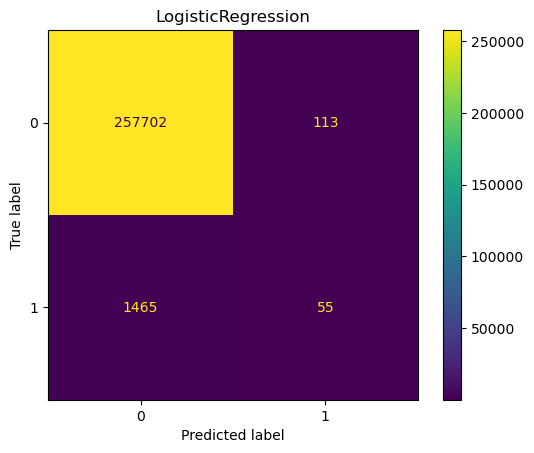

In [26]:
log_reg = LogisticRegression(n_jobs=-1)
parameters = {
    "penalty":["l1", "l2", "elasticnet"],
    "C": [0.1,0.5,1.0],
    "max_iter": [100,1000,2000,5000]
}
log_reg_gs = hyper_parameter_tuning(log_reg,parameters)
print(log_reg_gs.best_estimator_)
plot_confusion_matrix(y_test,log_reg_gs,X_test,'LogisticRegression')
measure_scores(log_reg_gs,X_test,y_test,'LogisticRegression')

In [27]:
print(f1_score_dict['LogisticRegression'],balanced_accuracy_scores_dict['LogisticRegression'])

0.06516587677725119 0.5178729558730913


#### KNN

KNeighborsClassifier(n_jobs=-1, n_neighbors=3)


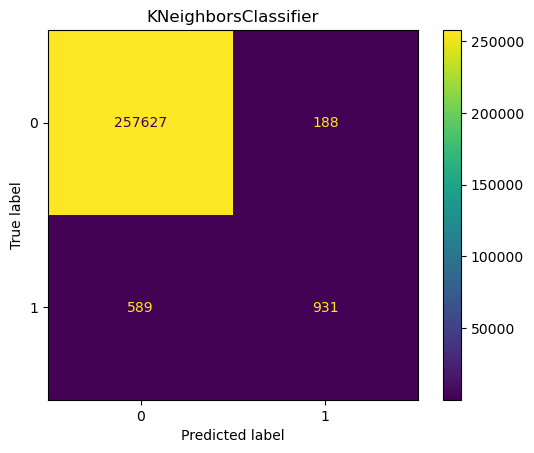

In [28]:
knn_m = KNeighborsClassifier(n_jobs=-1)
params = {
    "n_neighbors": np.array(range(1,5))
}
knn_gs = hyper_parameter_tuning(knn_m,params)
print(knn_gs.best_estimator_)
plot_confusion_matrix(y_test,knn_gs,X_test,'KNeighborsClassifier')
measure_scores(knn_gs,X_test,y_test,'KNeighborsClassifier')

In [29]:
print(f1_score_dict['KNeighborsClassifier'],balanced_accuracy_scores_dict['KNeighborsClassifier'])


0.7055702917771883 0.8058853974749336


#### Decision Tree

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


DecisionTreeClassifier(max_depth=10)


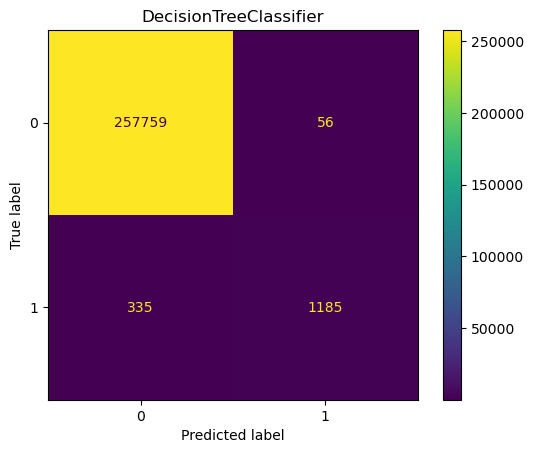

In [30]:
tree_m = DecisionTreeClassifier()
tree_parameter = {
"max_depth": np.array(range(1,15))
}
tree_gs = hyper_parameter_tuning(tree_m,tree_parameter)
print(tree_gs.best_estimator_)
plot_confusion_matrix(y_test,tree_gs,X_test,'DecisionTreeClassifier')
measure_scores(tree_gs,X_test,y_test,'DecisionTreeClassifier')

In [31]:
print(f1_score_dict['DecisionTreeClassifier'],balanced_accuracy_scores_dict['DecisionTreeClassifier'])


0.858384643245201 0.8896940265714808


#### SVM

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/

LinearSVC(C=0.1, penalty='l1')


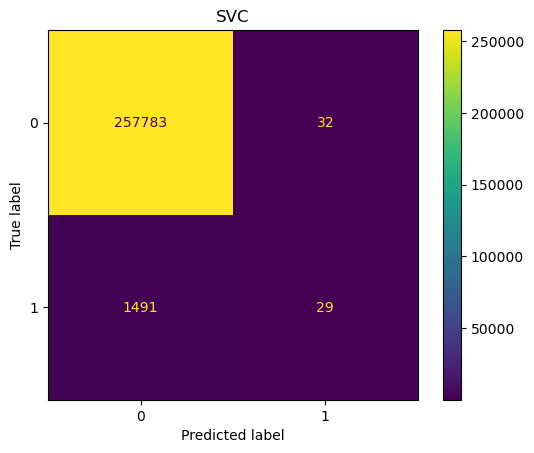

In [32]:
lsvc = LinearSVC()
l_params = {
    'C':[0.1,1.0,10,100],
    'penalty':['l1', 'l2']
}
lsvc_gs = hyper_parameter_tuning(lsvc,l_params)
print(lsvc_gs.best_estimator_)
plot_confusion_matrix(y_test,lsvc_gs,X_test,'SVC')
measure_scores(lsvc_gs,X_test,y_test,'SVC')

In [33]:
print(f1_score_dict['SVC'],balanced_accuracy_scores_dict['SVC'])


0.036685641998734975 0.5094774136799439


#### Score comparision

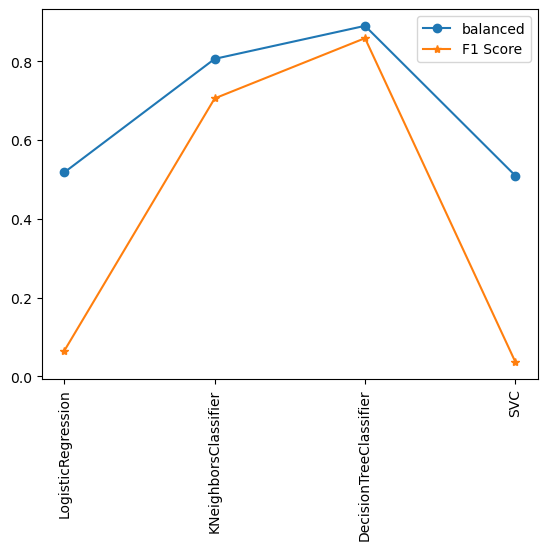

In [34]:
plt.plot(balanced_accuracy_scores_dict.keys(),balanced_accuracy_scores_dict.values(),label='balanced',marker='o')
plt.plot(f1_score_dict.keys(),f1_score_dict.values(),label='F1 Score',marker='*')
plt.xticks(rotation=90)
plt.legend()
plt.show()

##### Decision Tree has better scores compared to the other ones

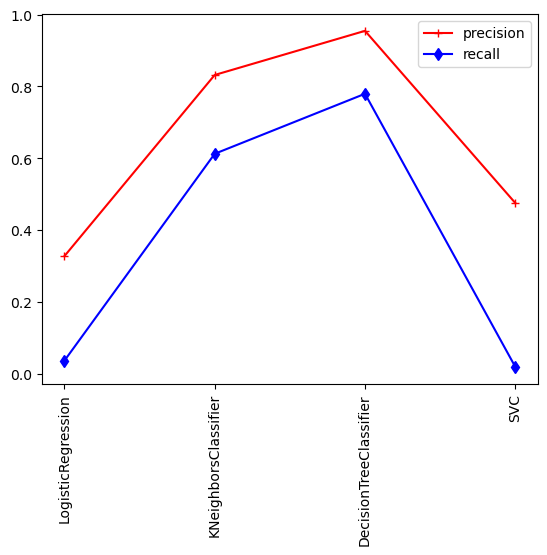

In [35]:
plt.plot(precision_dict.keys(),precision_dict.values(),label='precision',marker='+',color='r')
plt.plot(recall_dict.keys(),recall_dict.values(),label='recall',marker = 'd',color='b')
plt.xticks(rotation=90)
plt.legend()
plt.show()

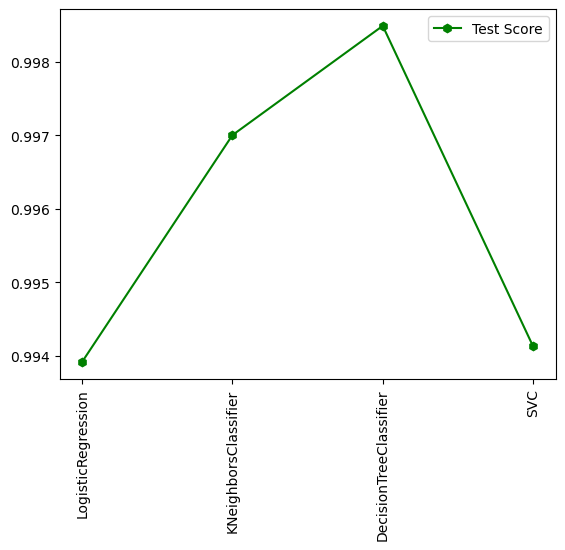

In [36]:
plt.plot(model_test_scores.keys(),model_test_scores.values(),label='Test Score',marker='h',color='g')
plt.xticks(rotation=90)
plt.legend()
plt.show()

#### Next Steps
Use the ensemble techniques and other neural network models 

### Ensemble Techniques

Using the following ensemble techniques to evaluate the models and find out the best model.

* BaggingClassifier
* AdaBoostClassifier
* BalancedRandomForestClassifier
* RUSBoostingClassifier
* RandomForestClassifier

#### BaggingClassifier

In [37]:
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn import tree


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warning

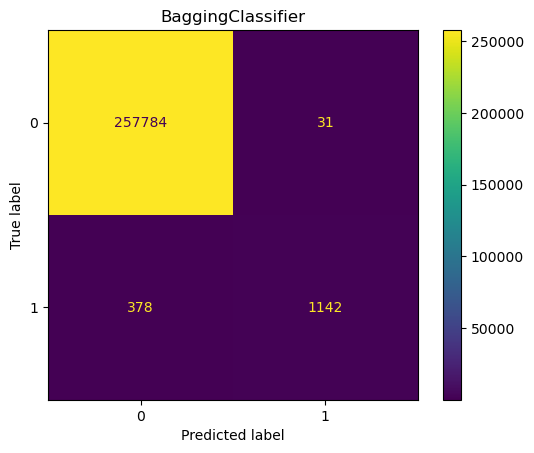

In [38]:
r_bc = RandomForestClassifier(n_jobs=-1)
bc = BaggingClassifier(estimator=r_bc,random_state=42).fit(X_train,y_train)
plot_confusion_matrix(y_test,bc,X_test,'BaggingClassifier')
measure_scores(bc,X_test,y_test,'BaggingClassifier')

In [39]:
print(balanced_accuracy_scores_dict['BaggingClassifier'])


0.8755977741077088


The balanced score of the BaggingClassifer model is 87% accuracy in predicting both true positive and true negative.

#### AdaBoostingClassifier

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


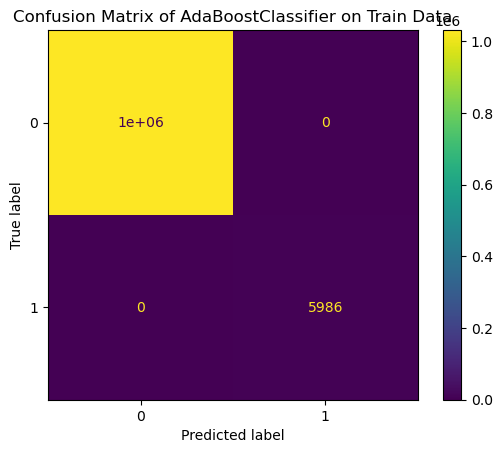

In [40]:
r = RandomForestClassifier(n_jobs=-1)
ada = AdaBoostClassifier(r).fit(X_train,y_train)
plot_confusion_matrix(y_train,ada,X_train,'Confusion Matrix of AdaBoostClassifier on Train Data')
measure_scores(ada,X_test,y_test,'AdaBoostClassifier')

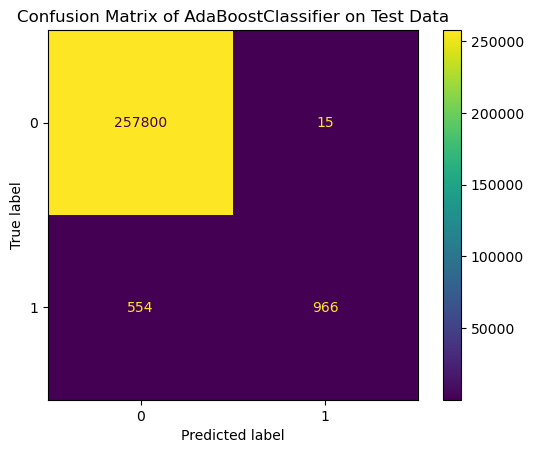

In [41]:
plot_confusion_matrix(y_test,ada,X_test,'Confusion Matrix of AdaBoostClassifier on Test Data')


In [42]:
print(balanced_accuracy_scores_dict['AdaBoostClassifier'],f1_score_dict['AdaBoostClassifier'])


0.8177340672677369 0.7724910035985606


AdaBoostClassifier's balanced score is close to 81%.

#### BalancedRandomForestClassifier

In [45]:
from imblearn.ensemble import BalancedRandomForestClassifier


/opt/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


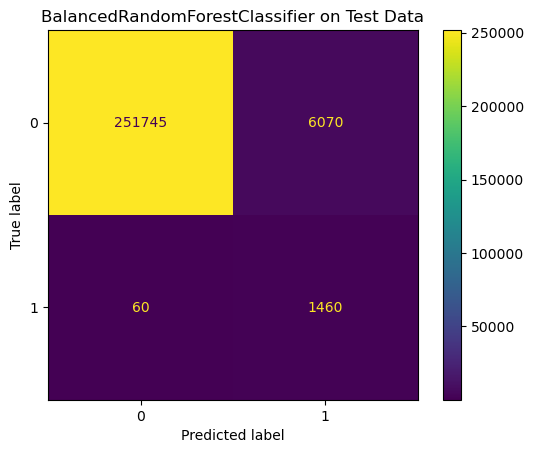

In [46]:
brfc = BalancedRandomForestClassifier(n_estimators=100, random_state=0, sampling_strategy="all", replacement=True,n_jobs=-1).fit(X_train,y_train)
plot_confusion_matrix(y_test,brfc,X_test,'BalancedRandomForestClassifier on Test Data')
measure_scores(brfc,X_test,y_test,'BalancedRandomForestClassifier')

In [47]:
print(balanced_accuracy_scores_dict['BalancedRandomForestClassifier'], f1_score_dict['BalancedRandomForestClassifier'])


0.9684911508354114 0.32265193370165746


BalancedRandomForestClassifier is predicting true positive score of 96% which is performing better than other models.

#### RUSBoostingClassifier

In [48]:
from imblearn.ensemble import RUSBoostClassifier


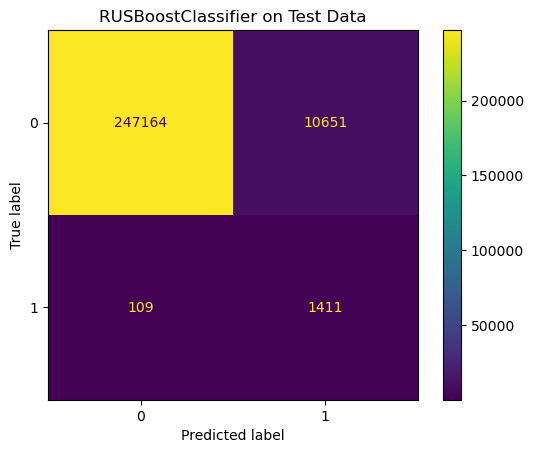

In [49]:
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0).fit(X_train,y_train)
plot_confusion_matrix(y_test,rusboost,X_test,'RUSBoostClassifier on Test Data')
measure_scores(rusboost,X_test,y_test,'RUSBoostClassifier')

In [50]:
print(balanced_accuracy_scores_dict['RUSBoostClassifier'])


0.9434884522969857


RSUBoostClassifier is predicting accurately on the true positive of 94%.



#### RandomForestClassifier

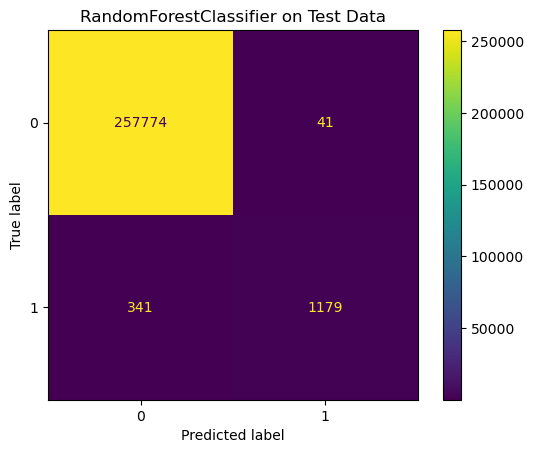

In [51]:
rfc = RandomForestClassifier(n_jobs=-1).fit(X_train,y_train)
plot_confusion_matrix(y_test,rfc,X_test,'RandomForestClassifier on Test Data')
measure_scores(rfc,X_test,y_test,'RandomForestClassifier')

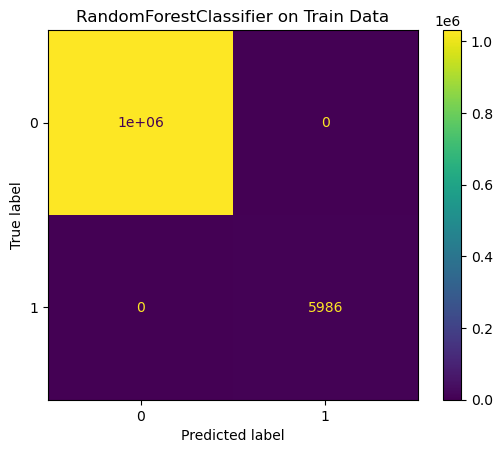

In [52]:
plot_confusion_matrix(y_train,rfc,X_train,'RandomForestClassifier on Train Data')


In [53]:
print(balanced_accuracy_scores_dict['RandomForestClassifier'])


0.8877494329879545


RandomForestClassifier is predicting accurately on the true positive of 88%.


### Ensemble  Observations


Most of these ensemble models are performing better than the standard models. BalancedRandomForestClassifier is the bettter one compared to the other ensemble models.

### Models comparision

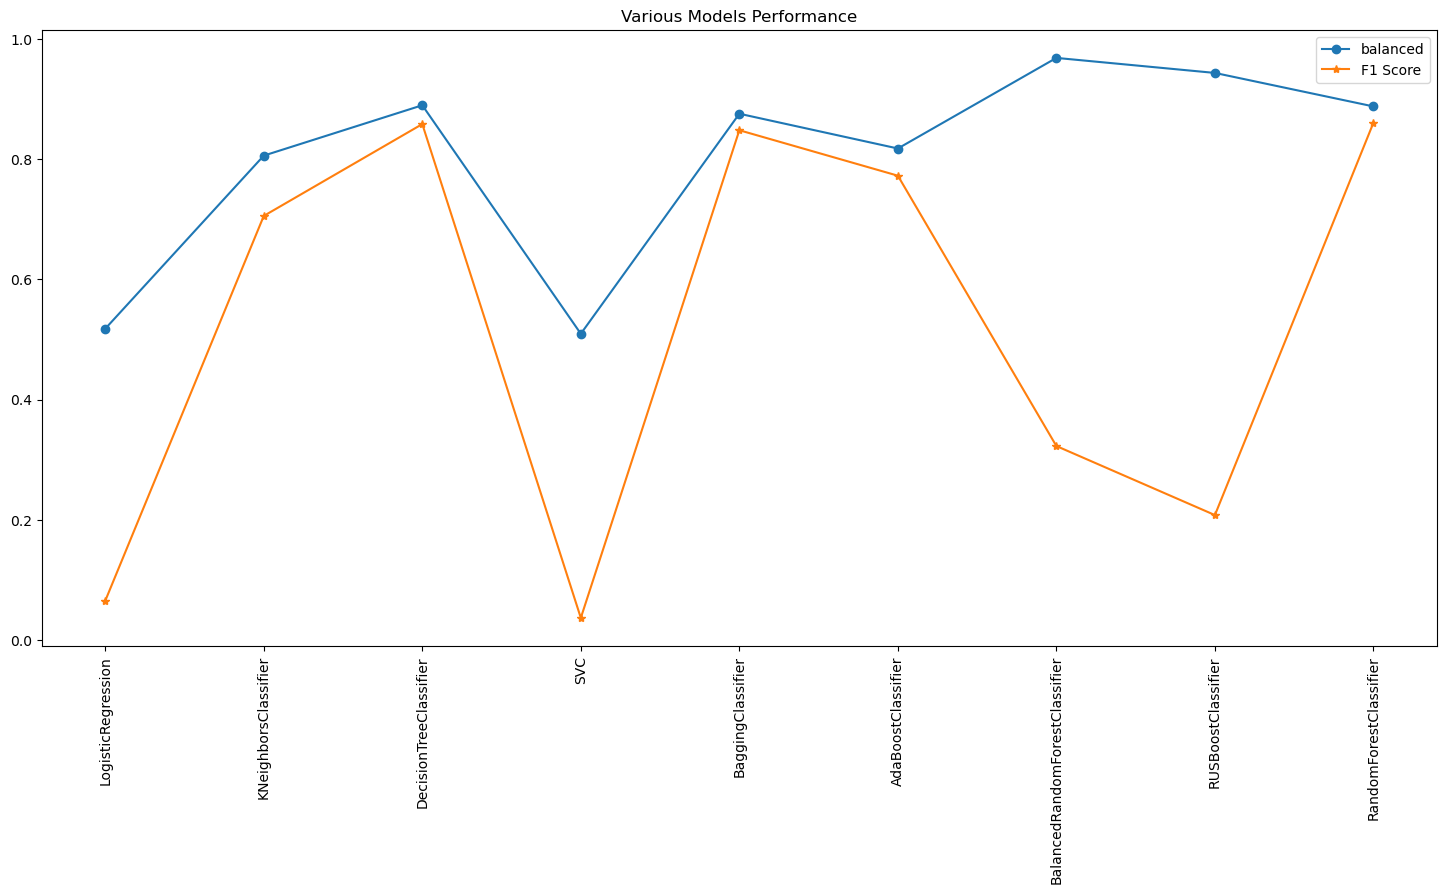

In [54]:
plt.figure(figsize=(18,8))
plt.plot(balanced_accuracy_scores_dict.keys(),balanced_accuracy_scores_dict.values(),label='balanced',marker='o')
plt.plot(f1_score_dict.keys(),f1_score_dict.values(),label='F1 Score',marker='*')
plt.xticks(rotation=90)
plt.title('Various Models Performance')
plt.legend()
plt.show()

### Deployment

We can use the BalancedRandomForestClassifier as the final model since that is performing better than the other ones

In [58]:
card_transaction_test_df = pd.read_csv('data/fraudTest.csv')
card_transaction_test_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


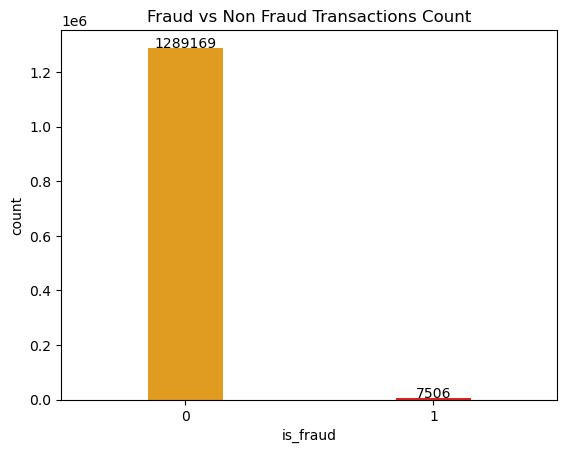

In [59]:
plot = sns.countplot(card_transaction_df,x='is_fraud',width=0.3,palette=['orange',"red"])
plot.text(0,len(card_transaction_df.query("is_fraud == 0")),len(card_transaction_df.query("is_fraud == 0")),horizontalalignment='center')
plot.text(1,len(card_transaction_df.query("is_fraud == 1")),len(card_transaction_df.query("is_fraud == 1")),horizontalalignment='center')
plt.title('Fraud vs Non Fraud Transactions Count')
plt.show()

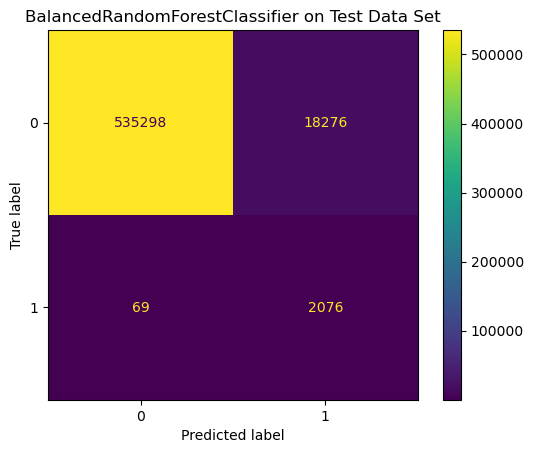

In [62]:
#load dataset
card_transaction_test_df = pd.read_csv('data/fraudTest.csv')
card_transaction_test_df.head()

card_transaction_test_df.drop(columns=['Unnamed: 0','cc_num','trans_num','first','last','merchant','zip','city_pop','street','unix_time'],axis=1,inplace=True)

card_transaction_test_df['transaction_hour'] = pd.to_datetime(card_transaction_test_df['trans_date_trans_time'],format="%Y-%m-%d %H:%M:%S").dt.hour
card_transaction_test_df.drop('trans_date_trans_time',axis=1,inplace=True)


current_year = datetime.date.today().year
card_transaction_test_df['customer_age'] = current_year - pd.to_datetime(card_transaction_test_df['dob']).dt.year
card_transaction_test_df.drop('dob',axis=1,inplace=True)

card_transaction_test_df.drop('city',axis=1,inplace=True)

X = card_transaction_test_df.drop('is_fraud',axis=1)
y = card_transaction_test_df['is_fraud']

#encoding
X = JamesSteinEncoder().fit_transform(X,y)

# used StandardScaler to scale the features.
X = StandardScaler().fit_transform(X)

plot_confusion_matrix(y,brfc,X,'BalancedRandomForestClassifier on Test Data Set')

In [64]:
measure_scores(brfc,X,y,'BalancedRandomForestClassifier')

In [65]:
print(balanced_accuracy_scores_dict['BalancedRandomForestClassifier'])


0.9674088057563437


The above prediction is on the test data set using the BalancedRandomForestClassifier as our model and its score is more than 95% accuracy.